# Finding Similar Neighborhoods across the top two cities (Accra and Kumasi) in Ghana 

Table of content

1. <a href="#item1"><em>Introduction</a>    
2. <a href="#item1"><em>Data acquisition and manipulation</a>    
3. <a href="#item1"><em> k - means clustering, k - 4</a>    
4. <a href="#item1"><em> Model Evaluation (Elbow and Silhouette plots)</a>    
5. <a href="#item1"><em> Final Model (k - means clustering, k - 3)</a>    
6. <a href="#item1"><em> GMM clustering - 3 components</a>    

### Introduction

The choice of a particular neighborhood stems from several factors depending on the entity making the choice. For home buyers, neighborhoods are essential as it forms an integral part of their lives. For example, the quality of housing, school and health care in part depends on one’s neighborhood. For business entities, location matters for business success and hence companies spend a lot of time making sure that they choose the best neighborhood for their business to thrive.

Since neighborhoods form an integral part of people’s lives, most people would like to live in a neighborhood (similar to their former neighborhood) when they move from one city to the other. Similarly, businesses that want to expand their business to other cities would like to find neighborhoods similar to their current business location. This project seeks to help businesses and people in finding appropriate neighborhoods in the top 2 cities in Ghana.

Background

For businesses to successfully expand their operations from one city to the other, there need to be a good understanding of how neighborhoods are segmented across several cities. In this regard, companies spend a lot of time making sure that they choose the best neighborhood for their business to thrive as they move from one city to the other. Likewise, as people move from one city to the other, they might prefer to live in a neighborhood similar to their former neighborhood. This because, neighborhoods form an integral part of one’s life. For example, the quality of schools and health care, the closeness of a coffee shop or a restaurant, among others. As a result, as people move from one city to the other, they might want neighborhoods with similar characteristics to their former neighborhood. Some may even consider the closeness of a police station or a fire department for security reasons. Hence, finding similar neighborhoods across cities is very important to both businesses and individual persons.

Problem

In this project, we seek to cluster neighborhoods in the top 2 cities in Ghana – Kumasi and Accra using Foursquare location data. Such an analysis will help businesses choose an appropriate neighborhood for their business as they expand their operations from one city to the other. Likewise, it will help people to choose which neighborhood to stay as they move from one of these two cities to the other, especially for long stays.

Also using the results, we will determine which neighborhoods (in both cities) will be appropriate for a clothing shop. Our target location will be in the vicinity of a bus station if the bus station appears to be a top venue in the neighborhood. The intuition behind the choice of this location is that, travelers tend to shop for a while as they wait for the departure of their bus. Hence, there might be a little more floating customers visiting the shop compared to other location. The caveat here is that the bus station should be a top venue.

Interest

The results of this project will be valuable to businesses and people who are moving from Accra to Kumasi, and vice versa. Also, the result of the second part of the project will be useful for investor seeking to invest in a clothing shop.

Data sources

The names of the neighborhoods in both cities are retrieved from several internet sources with the primary ones being https://en.wikipedia.org/wiki/Category:Populated_places_in_Kumasi_Metropolitan_Assembly, and https://en.wikipedia.org/wiki/Neighborhoods_of_Accra). We also use the Foursquare location dataset in this project, where we extract the top venues in the various neighborhoods. Also, we use the geopy library to extract the coordinates (latitude and longitude) of the various neighborhoods in the two cities. We also use data from the Ghana Living Standards Survey 7 (http://www2.statsghana.gov.gh/nada/index.php/catalog/97 ). This dataset contains some characteristics about the various neighborhoods used in our model. We will focus on 5 characteristics including population of the neighborhood, permanent daily community market, occasional road impasses, post office and the number of junior high schools and primary schools in the neighborhood/community.

Let's start by importing useful libraries


In [483]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Now we will the coordinates for the neighborhoods in Accra

### Data Acquisition and Manipulation

In [484]:
accra_neighborhoods = ["Kisseman, Accra", "Taifa, Accra", "Sakumono, Accra","Ridge, Accra","Osu, Accra", "Ofankor, Accra","Nungua, Accra","Nima, Accra","Mamprobi, Accra", 
    "Lashibi, Accra","La, Accra","Korle bu, Accra","Kokomlemle, Accra","Kanda, Accra", "James town, Accra", "Dzorwulu, Accra", "Teshie, Accra","Chorkor, Accra","Bubuashie, Accra",
                       "Abossey okai, Accra","Adenta, Accra", "Ashongman, Accra","Alajo, Accra","Darkuman, Accra", "Ashaiman, Accra"]

Latitude = []
Longitude = []
for i in accra_neighborhoods:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(i) #this gets the latitude and longitude coordinates of the address specified above
    latitude = location.latitude
    longitude = location.longitude
    Latitude.append(latitude)
    Longitude.append(longitude)
    #print('The geograpical coordinate of', (i), 'are {}, {}.'.format(latitude, longitude))

Next, we will put the information above into a dataframe and clean it

In [485]:
df = pd.DataFrame() # create empty dataframe
df['Borough'] = accra_neighborhoods

In [486]:
df['Latitude'] = Latitude

In [487]:
df['Longitude'] = Longitude

In [488]:
df.head()

,Borough,Latitude,Longitude
0,"Kisseman, Accra",5.640390,-0.215731
1,"Taifa, Accra",5.658389,-0.252853
2,"Sakumono, Accra",5.622624,-0.069409
3,"Ridge, Accra",5.560014,-0.205744
4,"Osu, Accra",5.560593,-0.182439


In [489]:
df.shape

(25, 3)

In [490]:
df['Neighborhood'] =  df.Borough

In [491]:
df.Neighborhood = df.Neighborhood.str[:-7] #remove the last three characters

In [492]:
df.head()

,Borough,Latitude,Longitude,Neighborhood
0,"Kisseman, Accra",5.640390,-0.215731,Kisseman
1,"Taifa, Accra",5.658389,-0.252853,Taifa
2,"Sakumono, Accra",5.622624,-0.069409,Sakumono
3,"Ridge, Accra",5.560014,-0.205744,Ridge
4,"Osu, Accra",5.560593,-0.182439,Osu


In [493]:
new = df["Borough"].str.split(",", n = 1, expand = True)

In [494]:
new.head()

,0,1
0,Kisseman,Accra
1,Taifa,Accra
2,Sakumono,Accra
3,Ridge,Accra
4,Osu,Accra


In [495]:
df = df.drop(columns='Borough')

In [496]:
df['Borough'] = new.iloc[:,1]

In [497]:
df.head()

,Latitude,Longitude,Neighborhood,Borough
0,5.640390,-0.215731,Kisseman,Accra
1,5.658389,-0.252853,Taifa,Accra
2,5.622624,-0.069409,Sakumono,Accra
3,5.560014,-0.205744,Ridge,Accra
4,5.560593,-0.182439,Osu,Accra


In [498]:
df.to_csv('/home/jupyterlab/accradata.csv')

We will also extract the coordinates of the neighborhoods in Kumasi

In [499]:
Kumasi_neighborhoods = ["Abrepo, Kumasi", "Pankrono, Kumasi", "Ahinsan, Kumasi","Oforikrom, Kumasi",
                        "Amakom, Kumasi", "Manhyia, Kumasi","Suame, Kumasi", "Ayigya, Kumasi","Bantama, Kumasi",
                        "Kronum, Kumasi","Bohyen, Kumasi", "Breman, Kumasi","Tanoso, Kumasi","Tafo, Kumasi","Aboabo, Kumasi"]
Latitude = []
Longitude = []
for i in Kumasi_neighborhoods:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(i) #this gets the latitude and longitude coordinates of the address specified above
    latitude = location.latitude
    longitude = location.longitude
    Latitude.append(latitude)
    Longitude.append(longitude)
    #print('The geograpical coordinate of', (i), 'are {}, {}.'.format(latitude, longitude))

Again, let's put the information into a data frame and clean it

In [500]:
df2 = pd.DataFrame() # create empty dataframe
df2['G'] = Kumasi_neighborhoods

In [501]:
df2['Latitude'] = Latitude

In [502]:
df2['Longitude'] = Longitude

In [503]:
df2.head()

,G,Latitude,Longitude
0,"Abrepo, Kumasi",6.727268,-1.654274
1,"Pankrono, Kumasi",6.746895,-1.610982
2,"Ahinsan, Kumasi",6.663016,-1.599289
3,"Oforikrom, Kumasi",6.688504,-1.592580
4,"Amakom, Kumasi",6.690150,-1.606380


In [504]:
new2 = df2["G"].str.split(",", n = 1, expand = True)

In [505]:
new2.head(2)

,0,1
0,Abrepo,Kumasi
1,Pankrono,Kumasi


In [506]:
df2['Borough'] = new2.iloc[:,1]

In [507]:
df2['Neighborhood'] = new2.iloc[:,0]

In [508]:
df2 = df2.drop(columns='G')

In [509]:
df2.head()

,Latitude,Longitude,Borough,Neighborhood
0,6.727268,-1.654274,Kumasi,Abrepo
1,6.746895,-1.610982,Kumasi,Pankrono
2,6.663016,-1.599289,Kumasi,Ahinsan
3,6.688504,-1.592580,Kumasi,Oforikrom
4,6.690150,-1.606380,Kumasi,Amakom


In [510]:
df2.to_csv('/home/jupyterlab/kumasidata.csv')

In [511]:
df2.shape

(15, 4)

Now, we will join the two datasets

In [512]:
combined_data = df.append(df2)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [513]:
combined_data.shape

(40, 4)

In [514]:
combined_data

,Borough,Latitude,Longitude,Neighborhood
0,Accra,5.640390,-0.215731,Kisseman
1,Accra,5.658389,-0.252853,Taifa
2,Accra,5.622624,-0.069409,Sakumono
3,Accra,5.560014,-0.205744,Ridge
4,Accra,5.560593,-0.182439,Osu
5,Accra,5.654131,-0.264390,Ofankor
6,Accra,5.601139,-0.070385,Nungua
7,Accra,5.580888,-0.198852,Nima
8,Accra,5.535686,-0.240273,Mamprobi
9,Accra,5.636778,-0.063514,Lashibi


In [515]:
combined_data.to_csv('/home/jupyterlab/combined_data.csv')

Let's explore and cluster the neighborhoods across the two cities. We will check the number neighborhoods in the dataset

In [516]:
fulldata = combined_data
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(fulldata['Borough'].unique()),
        fulldata.shape[0]
    )
)

The dataframe has 2 boroughs and 40 neighborhoods.


We will use the geopy library to get the latitude and longitude values of Ghana.In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [517]:
#Use geopy library to get the latitude and longitude values of Toronto City.
from geopy.geocoders import Nominatim
address = 'Ghana'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address) #this gets the latitude and longitude coordinates of the address specified above
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ghana are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ghana are 8.0300284, -1.0800271.


In [518]:
%matplotlib inline

Create a map of Ghana with neighborhoods superimposed on top.

In [590]:
# create map of Toronto using latitude and longitude values
#Note that here we use the full data.
import folium # map rendering library
map_ghana = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, borough, neighborhood in zip(fulldata['Latitude'], fulldata['Longitude'], fulldata['Borough'], fulldata['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ghana)  
    
map_ghana

Now, let's Focus on Kumasi in order see the neighborhoods clearly. Create a map of Kumasi with neighborhoods superimposed on top.

In [520]:
#Remove white spaces
fulldata['Borough'] = fulldata['Borough'].apply(lambda x: x.strip())
fulldata['Neighborhood'] = fulldata['Neighborhood'].apply(lambda x: x.strip())

In [521]:
kumasi_data = fulldata[fulldata['Borough'] == 'Kumasi'].reset_index(drop=True)
kumasi_data.head()

,Borough,Latitude,Longitude,Neighborhood
0,Kumasi,6.727268,-1.654274,Abrepo
1,Kumasi,6.746895,-1.610982,Pankrono
2,Kumasi,6.663016,-1.599289,Ahinsan
3,Kumasi,6.688504,-1.592580,Oforikrom
4,Kumasi,6.690150,-1.606380,Amakom


In [522]:
#Use geopy library to get the latitude and longitude values of Toronto City.
from geopy.geocoders import Nominatim
address = 'Kumasi, Ghana'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address) #this gets the latitude and longitude coordinates of the address specified above
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kumasi, Ghana are {}, {}.'.format(latitude, longitude))



The geograpical coordinate of Kumasi, Ghana are 6.698081, -1.6230404.


let's zoom in the neighborhoods in Kumasi. Create a map of Accra with neighborhoods superimposed on top.

In [523]:
# create map of Toronto using latitude and longitude values
#Note that here we use the full data.
import folium # map rendering library
map_kumasi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(kumasi_data['Latitude'], kumasi_data['Longitude'], kumasi_data['Borough'], kumasi_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kumasi)  
    
map_kumasi

Also, let's Focus on Accra in order see the neighborhoods clearly. Create a map of Accra with neighborhoods superimposed on top.

In [524]:
accra_data = fulldata[fulldata['Borough'] == 'Accra'].reset_index(drop=True)
accra_data.head()

,Borough,Latitude,Longitude,Neighborhood
0,Accra,5.640390,-0.215731,Kisseman
1,Accra,5.658389,-0.252853,Taifa
2,Accra,5.622624,-0.069409,Sakumono
3,Accra,5.560014,-0.205744,Ridge
4,Accra,5.560593,-0.182439,Osu


In [525]:
#Use geopy library to get the latitude and longitude values of Toronto City.
from geopy.geocoders import Nominatim
address = 'Accra, Ghana'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address) #this gets the latitude and longitude coordinates of the address specified above
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Accra, Ghana are {}, {}.'.format(latitude, longitude))



The geograpical coordinate of Accra, Ghana are 5.5600141, -0.2057437.


In [526]:
# create map of Toronto using latitude and longitude values
#Note that here we use the full data.
import folium # map rendering library
map_accra = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(accra_data['Latitude'], accra_data['Longitude'], accra_data['Borough'], accra_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_accra)  
    
map_accra

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.Define Foursquare Credentials and Version¶

In [527]:
#Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
#Define Foursquare Credentials and Version

CLIENT_ID = 'GP44JHK2IBCMB4UPT552AURDDF24LK12K3MVEOIMWZX0E1D0' # your Foursquare ID
CLIENT_SECRET = 'WTXVRIFXJMKAW45ZETIKJOWOES0D5OQ4GYGQQSV5H5V41DZC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GP44JHK2IBCMB4UPT552AURDDF24LK12K3MVEOIMWZX0E1D0
CLIENT_SECRET:WTXVRIFXJMKAW45ZETIKJOWOES0D5OQ4GYGQQSV5H5V41DZC


Now let's explore a given neighborhood, say Ashaiman.


In [528]:
fulldata.loc[fulldata['Neighborhood'] == 'Ashaiman']

,Borough,Latitude,Longitude,Neighborhood
24,Accra,5.777222,-0.110485,Ashaiman


We see that the index of this row is 24, so we run the following code to select the neighborhood name

In [529]:
fulldata.loc[24, 'Neighborhood']

'Ashaiman'

Get the neighborhood's latitude and longitude values.

In [530]:
neighborhood_latitude = fulldata.loc[24, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = fulldata.loc[24, 'Longitude'] # neighborhood longitude value

neighborhood_name = fulldata.loc[24, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Ashaiman are 5.7772216, -0.110484749854872.


Now, let's get the top 100 venues that are in Ashaiman within a radius of 3000 meters.First, let's create the GET request URL. Name your URL url.¶

In [531]:
#Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.
#First, let's create the GET request URL. Name your URL url.
LIMIT = 40 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=GP44JHK2IBCMB4UPT552AURDDF24LK12K3MVEOIMWZX0E1D0&client_secret=WTXVRIFXJMKAW45ZETIKJOWOES0D5OQ4GYGQQSV5H5V41DZC&v=20180605&ll=5.7772216,-0.110484749854872&radius=3000&limit=40'

Send the GET request and examine the resutls

'https://api.foursquare.com/v2/venues/explore?&client_id=GP44JHK2IBCMB4UPT552AURDDF24LK12K3MVEOIMWZX0E1D0&client_secret=WTXVRIFXJMKAW45ZETIKJOWOES0D5OQ4GYGQQSV5H5V41DZC&v=20180605&l
l=43.7280205,-79.3887901&radius=500&limit=100'



In [532]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d07e87a38f2160025dbd42f'},
 'response': {'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 5.804221627000027,
    'lng': -0.08339755387018039},
   'sw': {'lat': 5.750221572999973, 'lng': -0.13757194583956361}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ffb1d0ee4b020891a2f1026',
       'name': 'Holy Bethos spa and ultraviolet treatment cerntre',
       'location': {'lat': 5.79200998958283,
        'lng': -0.12006458262282177,
        'labeledLatLngs': [{'label': 'display',
          'lat': 5.79200998958283,
          'lng': -0.12006458262282177}],
        'distance': 1958,
        'cc': 'GH',
      

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [533]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [534]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Holy Bethos spa and ultraviolet treatment cerntre,Spa,5.792010,-0.120065
1,Bakery - Valley View Uni,Bakery,5.795882,-0.122723
2,M.A. Bediako Grocery,Grocery Store,5.796907,-0.121992
3,Football Pitch - Valley View Uni,Soccer Field,5.798430,-0.123568
4,TK Beads Industry,Hobby Shop,5.781150,-0.135330


The table above shows the top venues in Ashaiman

In [535]:
print(len(nearby_venues), 'venues are close to Achimota')

5 venues are close to Achimota


And how many venues were returned by Foursquare?

In [536]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


Explore Neighborhoods in the two cities - Accra and Kumasi. Let's create a function to repeat the same process to all the neighborhoods in the two cities

In [537]:
#Repeat the process for all neiborhoods, not just marble hills
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's run the above function on each neighborhood and create a new dataframe called ghana_venues.

In [538]:
ghana_venues = getNearbyVenues(names=fulldata['Neighborhood'],
                                   latitudes=fulldata['Latitude'],
                                   longitudes=fulldata['Longitude']
                                  )

Kisseman
Taifa
Sakumono
Ridge
Osu
Ofankor
Nungua
Nima
Mamprobi
Lashibi
La
Korle bu
Kokomlemle
Kanda
James town
Dzorwulu
Teshie
Chorkor
Bubuashie
Abossey okai
Adenta
Ashongman
Alajo
Darkuman
Ashaiman
Abrepo
Pankrono
Ahinsan
Oforikrom
Amakom
Manhyia
Suame
Ayigya
Bantama
Kronum
Bohyen
Breman
Tanoso
Tafo
Aboabo


Let's check the size of the resulting dataframe

In [539]:
print(ghana_venues.shape)
ghana_venues.head()

(176, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kisseman,5.64039,-0.215731,Mercy Boutique wine n saloon,5.640038,-0.218052,Boutique
1,Kisseman,5.64039,-0.215731,Citizen Kwku Pub,5.639960,-0.218066,Pub
2,Kisseman,5.64039,-0.215731,Waakye,5.639935,-0.218162,Wings Joint
3,Kisseman,5.64039,-0.215731,One To Ten Supermarket,5.637801,-0.213231,Convenience Store
4,Kisseman,5.64039,-0.215731,Finest gifts Kisseman,5.637719,-0.212461,Gift Shop


Group the above data by the Neighborhood column

In [540]:
ghana_venues['Venue Category'].value_counts()

Fast Food Restaurant             13
African Restaurant               12
Bus Station                       7
Chinese Restaurant                7
Bar                               6
Hotel                             6
Bakery                            4
Pharmacy                          4
Science Museum                    4
Boutique                          4
Bed & Breakfast                   4
Snack Place                       3
Indian Restaurant                 3
American Restaurant               3
Cocktail Bar                      3
Shopping Mall                     3
Restaurant                        3
Electronics Store                 3
BBQ Joint                         3
Lounge                            2
Multiplex                         2
Pizza Place                       2
Mobile Phone Shop                 2
Salad Place                       2
History Museum                    2
Theme Park                        2
Soccer Field                      2
Furniture / Home Store      

In [541]:
dd = ghana_venues.groupby('Neighborhood').count()
dd.head(4)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aboabo,3,3,3,3,3,3
Abossey okai,4,4,4,4,4,4
Abrepo,1,1,1,1,1,1
Ahinsan,1,1,1,1,1,1


Now, let's plot the number of top Venues in Each Neighborhood

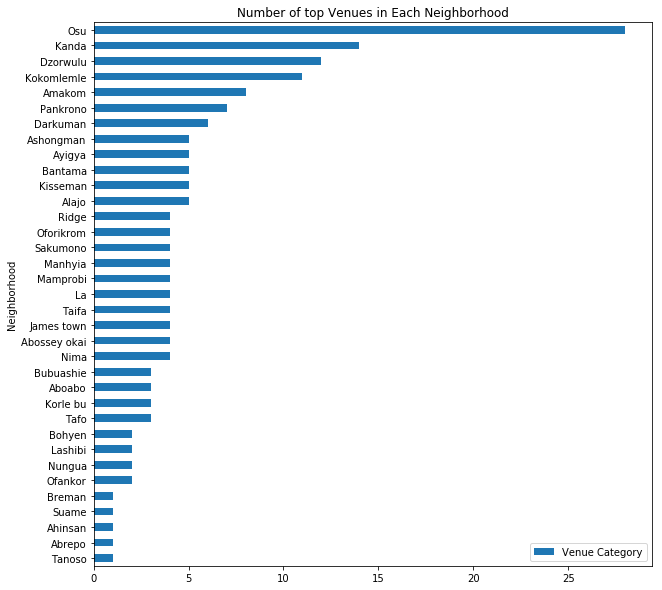

In [542]:
dd['Neighborhood'] = dd.index
dd.sort_values('Venue Category', ascending=True).plot.barh(x='Neighborhood', y='Venue Category', 
                                                           title = 'Number of top Venues in Each Neighborhood', rot=0, figsize=(10,10))

The first 4 Neighborhoods with highest number of close venues are in Accra. Accra is the capital of Ghana, and it is quite intuitive that neighborhoods in Accra will have more close venues

Let's check how many venues were returned for each neighborhood
Let's find out how many unique venue categories can be curated from all the returned venues

In [543]:
print('There are {} uniques categories.'.format(len(ghana_venues['Venue Category'].unique())))

There are 84 uniques categories.


Analyze Each Neighborhood

In [544]:
# one hot encoding just for the venue categoty column
ghana_onehot = pd.get_dummies(ghana_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ghana_onehot['Neighborhood'] = ghana_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ghana_onehot.columns[-1]] + list(ghana_onehot.columns[:-1])
ghana_onehot = ghana_onehot[fixed_columns]

ghana_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Auto Workshop,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Board Shop,Boutique,Bowling Alley,Brewery,Burger Joint,Bus Station,Chinese Restaurant,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hostel,Hotel,Indian Restaurant,Kebab Restaurant,Lawyer,Lighthouse,Lounge,Luggage Store,Mobile Phone Shop,Multiplex,Museum,Music Venue,Nightclub,Optical Shop,Pharmacy,Pizza Place,Pool,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Sandwich Place,Science Museum,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Spa,Sports Bar,Supermarket,Tennis Court,Theme Park,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Whisky Bar,Wings Joint,Women's Store
0,Kisseman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Kisseman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kisseman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Kisseman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Kisseman,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [545]:
ghana_onehot.to_csv('/home/jupyterlab/dataaa.csv')

And let's examine the new dataframe size.

In [546]:
ghana_onehot.shape

(176, 85)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [547]:
ghana_grouped = ghana_onehot.groupby('Neighborhood').mean().reset_index()
ghana_grouped

,Neighborhood,Accessories Store,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Auto Workshop,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Board Shop,Boutique,Bowling Alley,Brewery,Burger Joint,Bus Station,Chinese Restaurant,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hostel,Hotel,Indian Restaurant,Kebab Restaurant,Lawyer,Lighthouse,Lounge,Luggage Store,Mobile Phone Shop,Multiplex,Museum,Music Venue,Nightclub,Optical Shop,Pharmacy,Pizza Place,Pool,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Sandwich Place,Science Museum,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Spa,Sports Bar,Supermarket,Tennis Court,Theme Park,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Whisky Bar,Wings Joint,Women's Store
0,Aboabo,0.000000,0.333333,0.333333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.00,0.000000,0.00
1,Abossey okai,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.250000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.00,0.000000,0.25
2,Abrepo,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.00,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.00,0.000000,0.00
3,Ahinsan,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.00,0.000000,0.00
4,Alajo,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.600000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.2,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00

Let's confirm the new size

In [548]:
ghana_grouped.shape

(35, 85)

Let's print each neighborhood along with the top 2 most common venues¶


In [549]:
num_top_venues = 5

for hood in ghana_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ghana_grouped[ghana_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aboabo----
                venue  freq
0  African Restaurant  0.33
1     Airport Service  0.33
2         Fabric Shop  0.33
3           Multiplex  0.00
4                Pool  0.00


----Abossey okai----
                    venue  freq
0                Boutique  0.50
1           Women's Store  0.25
2  Furniture / Home Store  0.25
3               Multiplex  0.00
4                    Pool  0.00


----Abrepo----
               venue  freq
0         Food Truck   1.0
1  Accessories Store   0.0
2  Mobile Phone Shop   0.0
3               Pool   0.0
4        Pizza Place   0.0


----Ahinsan----
               venue  freq
0            Brewery   1.0
1  Accessories Store   0.0
2          Multiplex   0.0
3               Pool   0.0
4        Pizza Place   0.0


----Alajo----
                  venue  freq
0  Fast Food Restaurant   0.6
1           Golf Course   0.2
2                   Bar   0.2
3     Accessories Store   0.0
4             Multiplex   0.0


----Amakom----
                     venue  fr

Let's put that into a pandas dataframe. First, let's write a function to sort the venues in descending order.

In [550]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [551]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ghana_grouped['Neighborhood']

for ind in np.arange(ghana_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ghana_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aboabo,African Restaurant,Airport Service,Fabric Shop,Women's Store,Food,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
1,Abossey okai,Boutique,Women's Store,Furniture / Home Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop
2,Abrepo,Food Truck,Women's Store,Flower Shop,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop
3,Ahinsan,Brewery,Women's Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant
4,Alajo,Fast Food Restaurant,Golf Course,Bar,Gas Station,Furniture / Home Store,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store


A this stage, we will merge the data above with data from the Ghana Living standards Survey

In [552]:
glssdata = pd.read_csv('/resources/data/nb7.csv')

In [553]:
#merge data
nb = ghana_grouped.merge(glssdata, left_on='Neighborhood', right_on='Neighborhood', how = 'inner')

In [554]:
nb = nb.drop('Unnamed: 0', 1) #drop the neibaorhood column

In [555]:
nb = nb.drop('Borough', 1) #drop the neibaorhood column

In [556]:
nb.head()

,Neighborhood,Accessories Store,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Auto Workshop,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Board Shop,Boutique,Bowling Alley,Brewery,Burger Joint,Bus Station,Chinese Restaurant,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hostel,Hotel,Indian Restaurant,Kebab Restaurant,Lawyer,Lighthouse,Lounge,Luggage Store,Mobile Phone Shop,Multiplex,Museum,Music Venue,Nightclub,Optical Shop,Pharmacy,Pizza Place,Pool,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Sandwich Place,Science Museum,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Spa,Sports Bar,Supermarket,Tennis Court,Theme Park,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Whisky Bar,Wings Joint,Women's Store,population,occassional_road_impasses,post_office,permanent_daily_mkt,pm_jh_mean
0,Aboabo,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,17750.0,0.5,0.5,0.5,1.75
1,Abossey okai,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,12000.0,1.0,1.0,0.0,2.00
2,Abrepo,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,20000.0,0.0,0.0,1.0,2.00
3,Ahinsan,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,25000.0,0.0,1.0,0.0,2.00
4,Alajo,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,15000.0,0.0,1.0,1.0,2.00


### Cluster Neighborhoods (Run k-means to cluster the neighborhood into 4 clusters).


In [557]:
# set number of clusters
ghana_grouped_clustering = nb.drop('Neighborhood', 1) #drop the neibaorhood column

In [558]:
ghana_grouped_clustering.head()

,Accessories Store,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Auto Workshop,BBQ Joint,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Bistro,Board Shop,Boutique,Bowling Alley,Brewery,Burger Joint,Bus Station,Chinese Restaurant,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hostel,Hotel,Indian Restaurant,Kebab Restaurant,Lawyer,Lighthouse,Lounge,Luggage Store,Mobile Phone Shop,Multiplex,Museum,Music Venue,Nightclub,Optical Shop,Pharmacy,Pizza Place,Pool,Pub,Recording Studio,Rental Car Location,Restaurant,Salad Place,Sandwich Place,Science Museum,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Spa,Sports Bar,Supermarket,Tennis Court,Theme Park,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Whisky Bar,Wings Joint,Women's Store,population,occassional_road_impasses,post_office,permanent_daily_mkt,pm_jh_mean
0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,17750.0,0.5,0.5,0.5,1.75
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,12000.0,1.0,1.0,0.0,2.00
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,20000.0,0.0,0.0,1.0,2.00
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,25000.0,0.0,1.0,0.0,2.00
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,15000.0,0.0,1.0,1.0,2.00


In [559]:
#Normalizing population column
ghana_grouped_clustering['population_norm']=(ghana_grouped_clustering.population - ghana_grouped_clustering.population.mean())/ghana_grouped_clustering.population.std() #mean normalisation
ghana_grouped_clustering = ghana_grouped_clustering.drop(columns='population')

### run k-means clustering, k =4

In [560]:
# run k-means clustering
# import k-means from clustering stage
from sklearn.cluster import KMeans

kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ghana_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] #first 10 cluster labels

array([3, 3, 0, 3, 1, 1, 3, 1, 1, 1], dtype=int32)

Let's insert the cluster labels into the data

In [561]:
#merge cluster data to previous data
# add clustering labels
ghana_data = fulldata
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ghana_merged = ghana_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ghana_merged = ghana_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [562]:
ghana_merged.head(5) # first five rows

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Accra,5.640390,-0.215731,Kisseman,0.0,Pub,Boutique,Gift Shop,Convenience Store,Wings Joint,American Restaurant,Food,Airport Service,Dive Bar,Donut Shop
1,Accra,5.658389,-0.252853,Taifa,1.0,Bus Station,Snack Place,Restaurant,Food & Drink Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
2,Accra,5.622624,-0.069409,Sakumono,1.0,Chinese Restaurant,Optical Shop,American Restaurant,Fast Food Restaurant,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
3,Accra,5.560014,-0.205744,Ridge,0.0,Science Museum,History Museum,Indian Restaurant,Women's Store,Fast Food Restaurant,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
4,Accra,5.560593,-0.182439,Osu,1.0,African Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant,Shopping Mall,Pizza Place,Bed & Breakfast,Food Court,Food,Kebab Restaurant


In [563]:
ghana_merged['Cluster Labels'].unique()

array([ 0.,  1.,  2.,  3., nan])

Checking Total number of missing values

In [564]:
print (ghana_merged.isnull().sum().sum())

55


count number of missing values in each column

In [565]:
### count number of missing values in each column
ghana_merged.isna().sum()

Borough                   0
Latitude                  0
Longitude                 0
Neighborhood              0
Cluster Labels            5
1st Most Common Venue     5
2nd Most Common Venue     5
3rd Most Common Venue     5
4th Most Common Venue     5
5th Most Common Venue     5
6th Most Common Venue     5
7th Most Common Venue     5
8th Most Common Venue     5
9th Most Common Venue     5
10th Most Common Venue    5
dtype: int64

drop rows with mising values

In [566]:
#drop rows with mising values
ghana_merged=ghana_merged.dropna()

check again for missing values

In [567]:
# check again for missing values
ghana_merged.isna().sum()

Borough                   0
Latitude                  0
Longitude                 0
Neighborhood              0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

In [568]:
ghana_merged['Cluster Labels'].unique()

array([0., 1., 2., 3.])

In [569]:
ghana_merged.head(2)

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Accra,5.640390,-0.215731,Kisseman,0.0,Pub,Boutique,Gift Shop,Convenience Store,Wings Joint,American Restaurant,Food,Airport Service,Dive Bar,Donut Shop
1,Accra,5.658389,-0.252853,Taifa,1.0,Bus Station,Snack Place,Restaurant,Food & Drink Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop


In [570]:
ghana_merged.reset_index(drop=True)

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Accra,5.640390,-0.215731,Kisseman,0.0,Pub,Boutique,Gift Shop,Convenience Store,Wings Joint,American Restaurant,Food,Airport Service,Dive Bar,Donut Shop
1,Accra,5.658389,-0.252853,Taifa,1.0,Bus Station,Snack Place,Restaurant,Food & Drink Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
2,Accra,5.622624,-0.069409,Sakumono,1.0,Chinese Restaurant,Optical Shop,American Restaurant,Fast Food Restaurant,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
3,Accra,5.560014,-0.205744,Ridge,0.0,Science Museum,History Museum,Indian Restaurant,Women's Store,Fast Food Restaurant,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
4,Accra,5.560593,-0.182439,Osu,1.0,African Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant,Shopping Mall,Pizza Place,Bed & Breakfast,Food Court,Food,Kebab Restaurant
5,Accra,5.654131,-0.264390,Ofankor,2.0,Pharmacy,Dive Bar,Women's Store,Fast Food Restaurant,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Donut Shop,Electronics Store,Fabric Shop
6,Accra,5.601139,-0.070385,Nungua,1.0,Theme Park,Donut Shop,Women's Store,Flower Shop,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Electronics Store,Fabric Shop
7,Accra,5.580888,-0.198852,Nima,1.0,Pool,Music Venue,Salad Place,Bar,Fabric Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar
8,Accra,5.535686,-0.240273,Mamprobi,3.0,BBQ Joint,African Restaurant,Hotel,Women's Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
9,Accra,5.636778,-0.063514,Lashibi,1.0,African Restaurant,Boutique,Women's Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop


Let's reformat the index of our dataframe

In [571]:
step = 1
ghana_merged.index = pd.RangeIndex(start=0, stop=len(ghana_merged.index) , step=step)

In [572]:
ghana_merged.head(2)

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Accra,5.640390,-0.215731,Kisseman,0.0,Pub,Boutique,Gift Shop,Convenience Store,Wings Joint,American Restaurant,Food,Airport Service,Dive Bar,Donut Shop
1,Accra,5.658389,-0.252853,Taifa,1.0,Bus Station,Snack Place,Restaurant,Food & Drink Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop


In [573]:
ghana_merged.dtypes

Borough                    object
Latitude                  float64
Longitude                 float64
Neighborhood               object
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

we need to change the type of the Cluster Lables columns to interger

In [574]:
ghana_merged["Cluster Labels"] = ghana_merged["Cluster Labels"].astype(int)

Finally, let's visualize the resulting clusters

In [591]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ghana_merged['Latitude'], ghana_merged['Longitude'], ghana_merged['Neighborhood'], ghana_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's again focus just on Kumasi

In [576]:
kumasi_merged = ghana_merged[ghana_merged['Borough'] == 'Kumasi'].reset_index(drop=True)
kumasi_merged.head(2)

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kumasi,6.727268,-1.654274,Abrepo,0,Food Truck,Women's Store,Flower Shop,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop
1,Kumasi,6.746895,-1.610982,Pankrono,0,African Restaurant,Vegetarian / Vegan Restaurant,Gym,Art Gallery,Auto Workshop,BBQ Joint,Multiplex,Women's Store,Flower Shop,Convenience Store


In [577]:
#Use geopy library to get the latitude and longitude values of Toronto City.
from geopy.geocoders import Nominatim
address = 'Kumasi, Ghana'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address) #this gets the latitude and longitude coordinates of the address specified above
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kumasi, Ghana are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Kumasi, Ghana are 6.698081, -1.6230404.


In [578]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kumasi_merged['Latitude'], kumasi_merged['Longitude'], kumasi_merged['Neighborhood'], kumasi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Again, let's again focus on the results of the clustering in Accra

In [579]:
accra_merged = ghana_merged[ghana_merged['Borough'] == 'Accra'].reset_index(drop=True)
accra_merged.head(2)

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Accra,5.640390,-0.215731,Kisseman,0,Pub,Boutique,Gift Shop,Convenience Store,Wings Joint,American Restaurant,Food,Airport Service,Dive Bar,Donut Shop
1,Accra,5.658389,-0.252853,Taifa,1,Bus Station,Snack Place,Restaurant,Food & Drink Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop


In [580]:
#Use geopy library to get the latitude and longitude values of Toronto City.
from geopy.geocoders import Nominatim
address = 'Accra, Ghana'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address) #this gets the latitude and longitude coordinates of the address specified above
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kumasi, Ghana are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Kumasi, Ghana are 5.5600141, -0.2057437.


In [581]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(accra_merged['Latitude'], accra_merged['Longitude'], accra_merged['Neighborhood'], accra_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters
#### Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1


In [582]:
ghana_merged.loc[ghana_merged['Cluster Labels'] == 0] ##

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Accra,5.640390,-0.215731,Kisseman,0,Pub,Boutique,Gift Shop,Convenience Store,Wings Joint,American Restaurant,Food,Airport Service,Dive Bar,Donut Shop
3,Accra,5.560014,-0.205744,Ridge,0,Science Museum,History Museum,Indian Restaurant,Women's Store,Fast Food Restaurant,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
21,Kumasi,6.727268,-1.654274,Abrepo,0,Food Truck,Women's Store,Flower Shop,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop
22,Kumasi,6.746895,-1.610982,Pankrono,0,African Restaurant,Vegetarian / Vegan Restaurant,Gym,Art Gallery,Auto Workshop,BBQ Joint,Multiplex,Women's Store,Flower Shop,Convenience Store
24,Kumasi,6.688504,-1.592580,Oforikrom,0,Gas Station,Bus Station,Airport Terminal,Pharmacy,Women's Store,Fast Food Restaurant,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
31,Kumasi,6.737500,-1.636271,Breman,0,Bakery,Women's Store,Food,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant
32,Kumasi,6.698067,-1.695886,Tanoso,0,African Restaurant,Women's Store,Food,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant


#### Cluster 2

In [583]:
ghana_merged.loc[ghana_merged['Cluster Labels'] == 1] ##

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Accra,5.658389,-0.252853,Taifa,1,Bus Station,Snack Place,Restaurant,Food & Drink Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
2,Accra,5.622624,-0.069409,Sakumono,1,Chinese Restaurant,Optical Shop,American Restaurant,Fast Food Restaurant,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
4,Accra,5.560593,-0.182439,Osu,1,African Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant,Shopping Mall,Pizza Place,Bed & Breakfast,Food Court,Food,Kebab Restaurant
6,Accra,5.601139,-0.070385,Nungua,1,Theme Park,Donut Shop,Women's Store,Flower Shop,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Electronics Store,Fabric Shop
7,Accra,5.580888,-0.198852,Nima,1,Pool,Music Venue,Salad Place,Bar,Fabric Shop,Clothing Store,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar
9,Accra,5.636778,-0.063514,Lashibi,1,African Restaurant,Boutique,Women's Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop
10,Accra,5.560014,-0.205744,La,1,Science Museum,History Museum,Indian Restaurant,Women's Store,Fast Food Restaurant,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
14,Accra,5.535797,-0.210364,James town,1,Lighthouse,Tourist Information Center,Football Stadium,Beach,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
19,Accra,5.600330,-0.212070,Alajo,1,Fast Food Restaurant,Golf Course,Bar,Gas Station,Furniture / Home Store,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
25,Kumasi,6.690150,-1.606380,Amakom,1,Fast Food Restaurant,Hotel,Comfort Food Restaurant,Sandwich Place,Electronics Store,Shopping Mall,Bus Station,Theme Park,Food Court,Fried Chicken Joint


#### Cluster 3

In [584]:
ghana_merged.loc[ghana_merged['Cluster Labels'] == 2] ##

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Accra,5.654131,-0.264390,Ofankor,2,Pharmacy,Dive Bar,Women's Store,Fast Food Restaurant,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Donut Shop,Electronics Store,Fabric Shop
20,Accra,5.590258,-0.251983,Darkuman,2,Food & Drink Shop,African Restaurant,Gym / Fitness Center,Bus Station,Bar,Mobile Phone Shop,Flower Shop,Convenience Store,Dive Bar,Donut Shop


#### Cluster 4

In [585]:
ghana_merged.loc[ghana_merged['Cluster Labels'] == 3] ##

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Accra,5.535686,-0.240273,Mamprobi,3,BBQ Joint,African Restaurant,Hotel,Women's Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
11,Accra,5.535832,-0.230774,Korle bu,3,African Restaurant,Tennis Court,Fast Food Restaurant,Women's Store,Flower Shop,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop
12,Accra,5.573678,-0.208465,Kokomlemle,3,Fast Food Restaurant,Sports Bar,Pizza Place,Pub,Cocktail Bar,Luggage Store,Bakery,Spa,Pharmacy,Wings Joint
13,Accra,5.572847,-0.201833,Kanda,3,Hotel,Accessories Store,Bakery,Music Venue,Electronics Store,Fast Food Restaurant,Lawyer,Bed & Breakfast,Bar,Cocktail Bar
15,Accra,5.613092,-0.199157,Dzorwulu,3,Grocery Store,Bakery,Pharmacy,Clothing Store,Salad Place,Bistro,Bed & Breakfast,Chinese Restaurant,Soccer Field,Optical Shop
16,Accra,5.580373,-0.239922,Bubuashie,3,Bus Station,Art Gallery,Fast Food Restaurant,Women's Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store
17,Accra,5.560779,-0.240995,Abossey okai,3,Boutique,Women's Store,Furniture / Home Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop
18,Accra,5.697026,-0.233819,Ashongman,3,Snack Place,Bar,Board Shop,Shop & Service,Chinese Restaurant,Football Stadium,Fabric Shop,Cocktail Bar,Comfort Food Restaurant,Convenience Store
23,Kumasi,6.663016,-1.599289,Ahinsan,3,Brewery,Women's Store,Flower Shop,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop,Electronics Store,Fabric Shop,Fast Food Restaurant
26,Kumasi,6.703895,-1.615271,Manhyia,3,Soccer Field,Whisky Bar,Museum,Lounge,Fast Food Restaurant,Cocktail Bar,Comfort Food Restaurant,Convenience Store,Dive Bar,Donut Shop


END

In [586]:
# add clustering labels
ghana_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

No handles with labels found to put in legend.


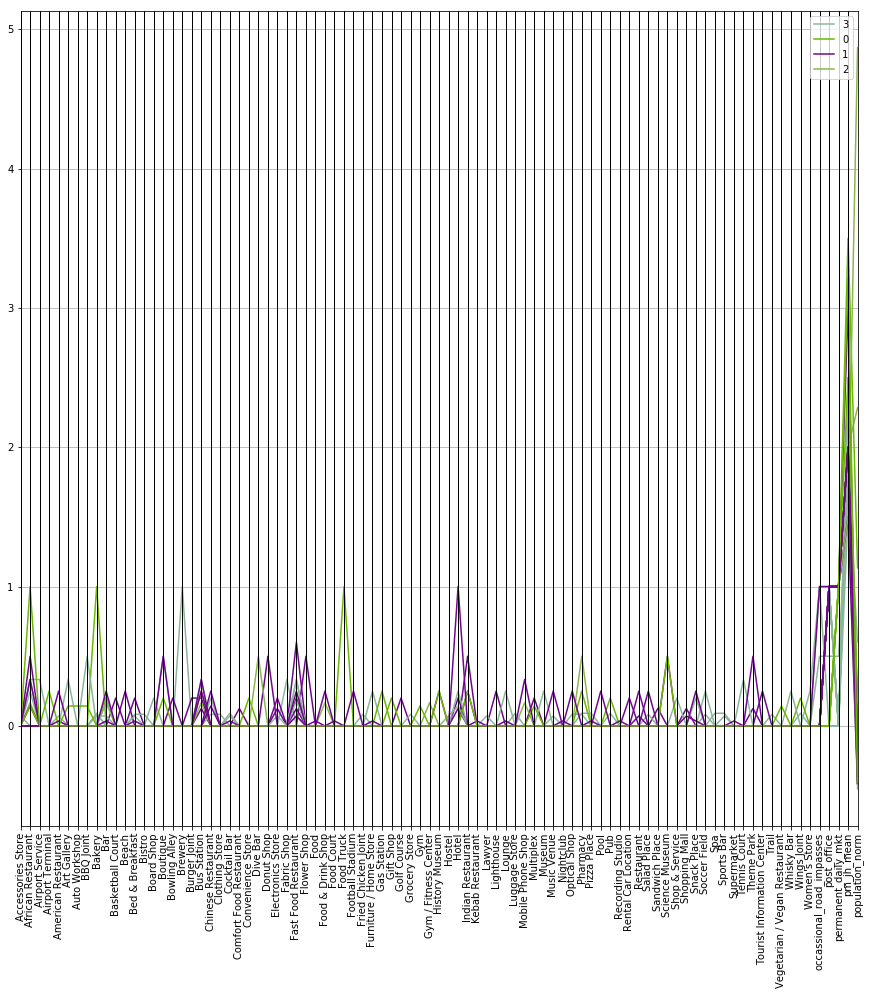

In [587]:
#parallelchord plot
import pandas
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(15,15))
plt.xticks(rotation='vertical')
plt.legend(loc='lower left')
parallel_coordinates(ghana_grouped_clustering, 'Cluster Labels')
plt.show()

### Model Evaluation

the evaluation of the cluster quality reveal that a 3 – cluster model would be a better fit to the data. This is being revealed by both the Silhouette plot and the elbow method of finding the optimal number of clusters.Follow this link (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for detailed documentation of the silhouette plot.


#### 1. Elbow method

In [588]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(ghana_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

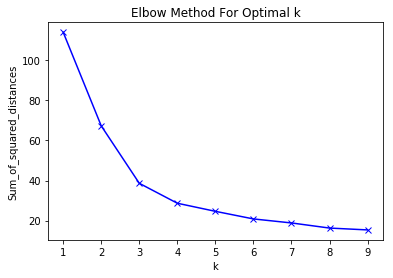

In [589]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [595]:
X = ghana_grouped_clustering.values

For n_clusters = 2 The average silhouette_score is : 0.4115742222722494
For n_clusters = 3 The average silhouette_score is : 0.4115742222722494
For n_clusters = 4 The average silhouette_score is : 0.4115742222722494
For n_clusters = 5 The average silhouette_score is : 0.4115742222722494
For n_clusters = 6 The average silhouette_score is : 0.4115742222722494


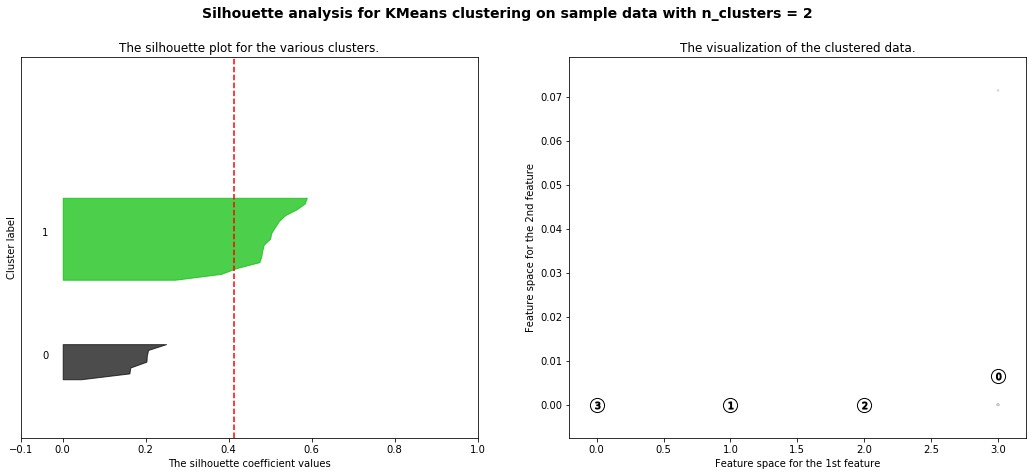

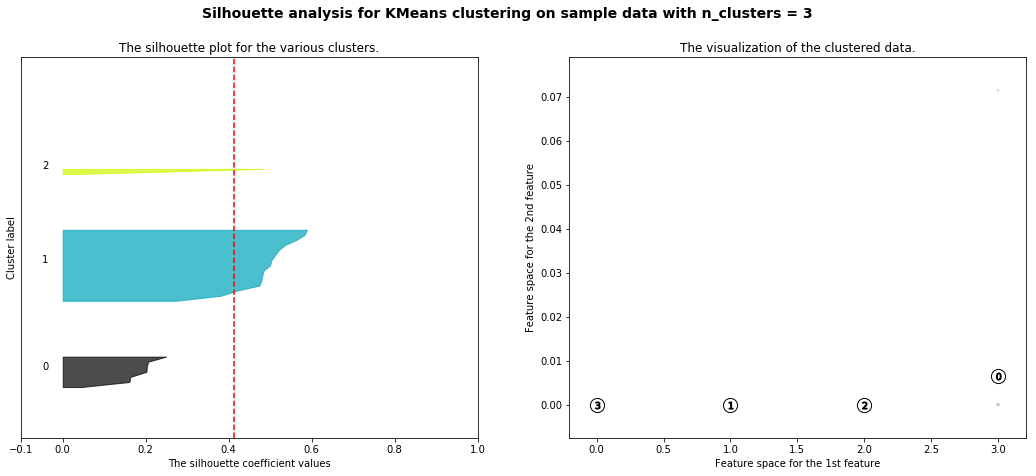

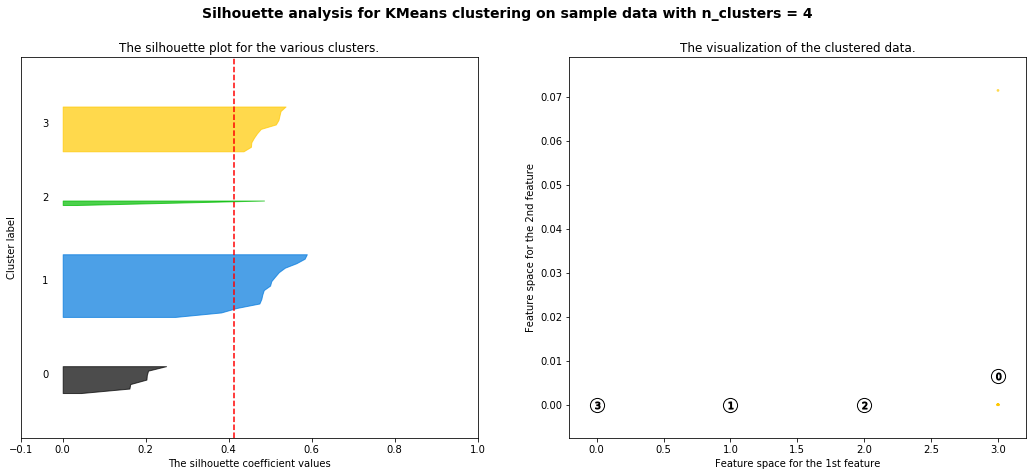

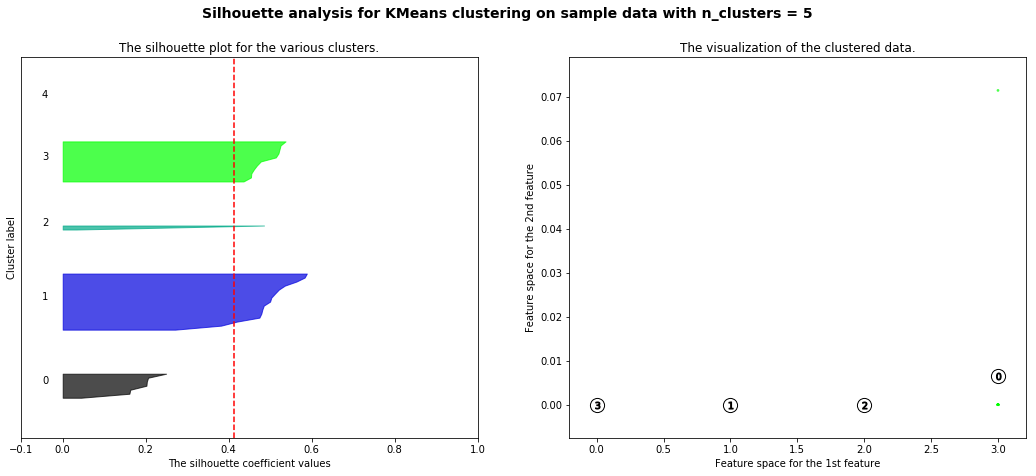

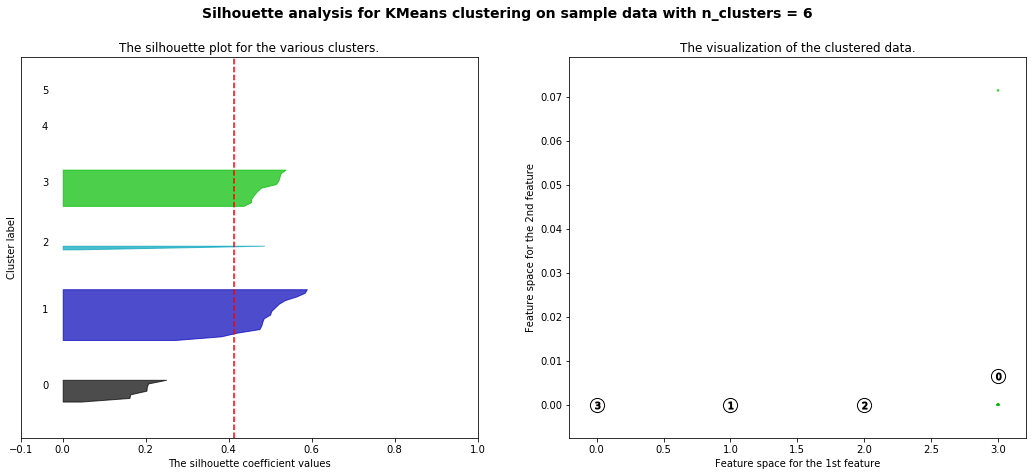

In [596]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=kclusters, random_state=0).fit(ghana_grouped_clustering)
    cluster_labels = kmeans.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## k means Clustering: k = 3

In [597]:
%%html
<a href="https://nbviewer.jupyter.org/github/EmmanuelAmeyaw/Capstone_project/blob/master/kmeans3%281%29.ipynb">Click here to see the notebook for 3-cluster kmeans model</a>
